In [1]:
%matplotlib inline

In [2]:
%%capture
import numpy as np
import time as tm
import matplotlib.pyplot as plt        
import matplotlib.gridspec as gridspec 
import networkx as nx
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tvb.simulator.lab import *


viridis= cm.get_cmap('viridis', 10)
cln=[viridis(4),viridis(4),viridis(4),'tomato',viridis(4),viridis(4)]
####################################################################

In [4]:
# CONFIGURE STRUCTURAL CONNECTIVITY
####################################################################
condspeed=np.infty 

SC6_con = connectivity.Connectivity(
    weights = np.array([
           [0.        , 0.1000757 , 0.130656  , 0.16900059, 0.1000757 , 0.130656  ],
           [0.100056  , 0.        , 0.090656  , 0.11799001, 0.1320757 , 0.138656  ],
           [0.11299001, 0.087656  , 0.        , 0.237     , 0.1340757 , 0.130656  ],
           [0.17000001, 0.1100757 , 0.132656  , 0.        , 0.1088757 , 0.138656  ],
           [0.10799001, 0.1000757 , 0.133656  , 0.10799001, 0.        , 0.120656  ],
           [0.12799001, 0.1400757 , 0.130656  , 0.137     , 0.1210757 , 0.        ]]
    ),
    tract_lengths = np.array(
        [[ 0., 40., 32., 33., 41., 60.],
         [40.,  0., 50., 26., 22., 30.],
         [32., 50.,  0., 60., 50., 40.],
         [33., 26., 60.,  0., 60., 40.],
         [41., 22., 50., 60.,  0., 30.],
         [60., 30., 40., 40., 30.,  0.]]),
    region_labels=np.array(['A','B','C','D','E','F'])
)
SC6_con.centres_spherical()
nregions = len(SC6_con.weights)   
SC6_con.speed = np.array([condspeed])
SC6_con.configure()


# STRUCTURAL GRAPH
G=nx.from_numpy_array(SC6_con.tract_lengths); weights = 15*SC6_con.weights[np.triu_indices(nregions,1)]

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


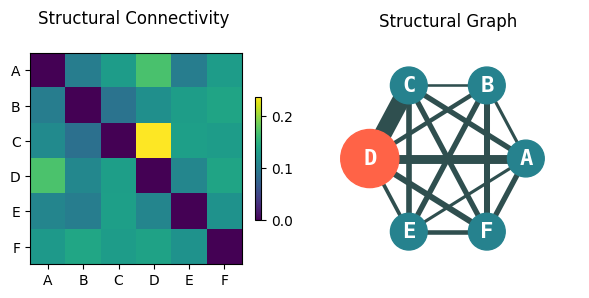

In [5]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Structural Connectivity \n')
plt.imshow(SC6_con.weights);plt.colorbar(shrink=0.5);
plt.xticks(np.arange(6),SC6_con.region_labels);plt.yticks(np.arange(6),SC6_con.region_labels);
plt.subplot(1,2,2)
plt.title('Structural Graph')
nx.draw_circular(G,labels=dict(enumerate(SC6_con.region_labels)),
                 width=weights**2, node_size=[700,700,700,2.5*700,700,700],
                 font_color='w',edge_color='darkslategray',font_size=16,font_weight='bold',
                 font_family='monospace',node_color=cln)
plt.axis('off')
axis = plt.gca()
axis.set_xlim(np.asarray([1.4*x for x in axis.get_xlim()]))
axis.set_ylim(np.asarray([1.4*y for y in axis.get_ylim()]))
plt.tight_layout();plt.show()

## CONFIGURE NEURAL MASS MODEL PARAMETERS

### We set node D with pathological levels of potassium concentration in the external bath $K_{bath}$

In [6]:
E = 0
K_bath = 15.5
J=0.08
eta=0
Delta=1
R_minus=0.02
R_plus=-0.1
c_minus=-44.24
c_plus=-20.4
Vstar = -31

In [7]:
THH = models.KIonEx(
            E = np.r_[E],
            K_bath = np.asarray([5.5,5.5,5.5,K_bath,5.5,5.5]),
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar])

In [8]:
THH

## CONFIGURE SIMULATION PARAMETERS

In [9]:
# Simulation parameters
dt = .1
cut_in=0
simlen=20e3+cut_in

#Initial conditions
x_0=np.random.uniform(low=0.1, high=0.1, size=((1,1,nregions,1)))
V_0=np.random.uniform(low=-15., high=-15., size=((1,1,nregions,1)))
n_0=np.random.uniform(low=0.45, high=0.45, size=((1,1,nregions,1)))
DKi_0=np.random.uniform(low=-5, high=-5, size=((1,1,nregions,1)))
Kg_0=np.random.uniform(low=-16., high=-16., size=((1,1,nregions,1)))
init_cond=np.concatenate([x_0, V_0, n_0, DKi_0, Kg_0], axis=1)

# I) Decoupled neural masses

In [10]:
G = 0.

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

## Initialise Integrator
heunint = integrators.RungeKutta4thOrderDeterministic(dt=dt)

# Initialise some Monitors with period in physical time.
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

In [11]:
####################################################################
# RUN the SIMULATION 
####################################################################
(raw_time, raw_data),  = sim.run()

In [12]:
# Make the lists numpy.arrays for easier use.  
RAW_variables_dec=np.squeeze(np.array(raw_data))   

x=RAW_variables_dec[:,0,:]
V=RAW_variables_dec[:,1,:]
n=RAW_variables_dec[:,2,:]
DKi=RAW_variables_dec[:,3,:]
Kg=RAW_variables_dec[:,4,:]

Vars=[x,V,n,DKi,Kg]
Vars_lab=['x','V','n','DKi','Kg']

### Node D shows pathological bursting due to excessive potassium concentration levels in the external bath. 
### This causes slow fluctuations of the intra- and extra-cellular potassium concentrations, 
### which trigger the fast membrane potential bursts.

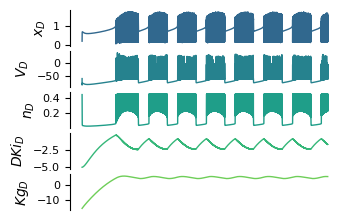

In [13]:
fig, ax = plt.subplots(nrows=5,ncols=1,figsize=(3.3,2.))
for i in range(5):
    ax[i].plot(Vars[i][:,3],c=viridis(i+3),linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])
    ax[i].set_ylabel('$%s_{D}$'%Vars_lab[i])
    ax[i].tick_params(labelsize=8)
plt.tight_layout(pad=0)
plt.show()

## Since the network is uncoupled ($G=0$), the pathological bursts do not propagate to other nodes

In [14]:
# The firing rate is proportional to the first variable 'x' 
r=(1000*R_minus/np.pi)*x

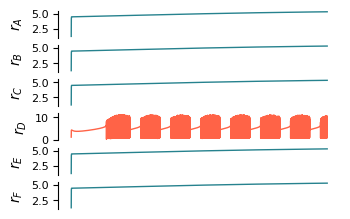

In [15]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.3,2.))
for i in range(6):
    ax[i].plot(r[:,i],c=cln[i],linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])
    ax[i].set_ylabel('$r_{%s}$'%SC6_labels[i])
    ax[i].tick_params(labelsize=8)
plt.tight_layout(pad=0)
plt.show()

# II) Coupled network

In [16]:
G = 100.

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

## Initialise Integrator
heunint = integrators.RungeKutta4thOrderDeterministic(dt=dt)

# Initialise some Monitors with period in physical time.
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

In [17]:
####################################################################
# RUN the SIMULATION 
####################################################################
(raw_time, raw_data),  = sim.run()

In [18]:
# Make the lists numpy.arrays for easier use.    
RAW_variables=np.squeeze(np.array(raw_data))   

# The firing rate is proportional to the first variable 'x' 
r=(1000*R_minus/np.pi)*RAW_variables[:,0,:]

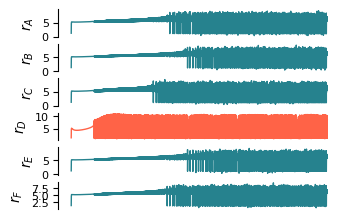

In [19]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.3,2.))
for i in range(6):
    ax[i].plot(r[:,i],c=cln[i],linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])
    ax[i].set_ylabel('$r_{%s}$'%SC6_labels[i])
    ax[i].tick_params(labelsize=8)
plt.tight_layout(pad=0)
plt.show()

### When the neural masses are coupled through the structural connectivity ($G=100$), the pathological bursts originating from high potassium levelspropagate in seizure-like events through the connectome. 

# CONCLUSION: 
## Local elevation of potassium bath concentration in a brain region can lead to the propagation of 
## pathological activities across the whole network. This model could serve as a computational baseline 
## to address core questions in epilepsy research. 
#
### Tutorial by Giovanni Rabuffo <giovanni.rabuffo@univ-amu.fr>

In [20]:
# Under the "NextGen" Research Infrastructure Voucher SC3 associated to the HBP Flagship as a Partnering Project (PP)
# Project leader: Simona Olmi <simone.olmi@gmail.com>
# EBRAINS Partner: Viktor Jirsa <viktor.jirsa@univ-amu.fr>
# Project member: Giovanni Rabuffo <giovanni.rabuffo@univ-amu.fr>
# Project member: Jan Fousek <jan.fousek@univ-amu.fr>